# Projet Big Data : Partie 1

## I] Collecte de données et étiquetage et annotation :

In [3]:
import os
def create_folder():
    if not os.path.exists('images'):
        os.makedirs('images')
    return

create_folder()

In [3]:
#Get our images on wikidata by a request
import sys
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get cities
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q1549591;
               wdt:P17 ?pays;
               wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 100"""

#fonction qui va exécuter notre requête vers wikidata
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["grandevilleLabel"]["value"],
            result["paysLabel"]["value"],
            result["image"]["value"],
        )
    )

In [4]:
# Put in a dataframe the data
dataframe = pd.DataFrame(array, columns=["ville", "pays", "image"])
dataframe = dataframe.astype(
    dtype={"ville": "<U200", "pays": "<U200", "image": "<U200"}
)
dataframe

,ville,pays,image
0,Dakar,Sénégal,http://commons.wikimedia.org/wiki/Special:File...
1,Addis-Abeba,Éthiopie,http://commons.wikimedia.org/wiki/Special:File...
2,Tripoli,Libye,http://commons.wikimedia.org/wiki/Special:File...
3,Asmara,Érythrée,http://commons.wikimedia.org/wiki/Special:File...
4,Neuss,Allemagne,http://commons.wikimedia.org/wiki/Special:File...
...,...,...,...
95,Alger,Algérie,http://commons.wikimedia.org/wiki/Special:File...
96,Bergisch Gladbach,Allemagne,http://commons.wikimedia.org/wiki/Special:File...
97,Moers,Allemagne,http://commons.wikimedia.org/wiki/Special:File...
98,Hildesheim,Allemagne,http://commons.wikimedia.org/wiki/Special:File...


In [14]:
import os
import re
import requests
from PIL import Image
from io import BytesIO
from urllib.parse import urlparse, unquote


def download_image(url):
    # Check if the URL ends with '.jpg' or '.png'
    if not url.endswith(('.jpg', '.JPG')):
        print('Skipping unsupported image URL:', url)
        return
    
    # Créez un dossier nommé "images" s'il n'existe pas déjà
    if not os.path.exists("images"):
        os.makedirs("images")
    
    # Clean URL
    url = unquote(url)

    # Extract the image name from the URL
    match = re.search(r'/([^/]+)\.(jpg|JPG)$', url)
    if match:
        filename = match.group(1) + '.' + match.group(2)
    else:
        filename = 'image.jpg'

    # Create the output path by combining the output folder and the filename
    output_path = os.path.join("images", filename)
    
    if os.path.exists(output_path):
        print('Image already exists:', output_path)
        return
    
    # Once we verified everything, we can download the image
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers)
    
    if request.status_code == 200:
        img = Image.open(BytesIO(request.content))
        
        # Get the EXIF data from the original image and save it to the new image
        exif_data = img.getexif()
        if exif_data is not None:
            img.save(output_path, exif=exif_data)
        else:
            img.save(output_path)
        
        return f"Image enregistrée avec succès dans le dossier 'images' : {filename}"
    else:
        return f"Échec de la requête avec le code d'état : {request.status_code}"


In [15]:
# We call the download fonction
dataframe.image.apply(download_image)

Skipping unsupported image URL: http://commons.wikimedia.org/wiki/Special:FilePath/Ciudad%20de%20Chill%C3%A1n.png
Skipping unsupported image URL: http://commons.wikimedia.org/wiki/Special:FilePath/%D0%9A%D1%80%D0%B0%D1%81%D0%BD%D0%BE%D0%B4%D0%B0%D1%80.png
Skipping unsupported image URL: http://commons.wikimedia.org/wiki/Special:FilePath/Algiers%20Montage.png
Skipping unsupported image URL: http://commons.wikimedia.org/wiki/Special:FilePath/MonroviaLB14.png
Skipping unsupported image URL: http://commons.wikimedia.org/wiki/Special:FilePath/Paramaribo%20city%20collage.png
Skipping unsupported image URL: http://commons.wikimedia.org/wiki/Special:FilePath/Algiers%20Icon.png


0     Image enregistrée avec succès dans le dossier ...
1     Image enregistrée avec succès dans le dossier ...
2     Image enregistrée avec succès dans le dossier ...
3     Image enregistrée avec succès dans le dossier ...
4     Image enregistrée avec succès dans le dossier ...
                            ...                        
95    Image enregistrée avec succès dans le dossier ...
96    Image enregistrée avec succès dans le dossier ...
97    Image enregistrée avec succès dans le dossier ...
98    Image enregistrée avec succès dans le dossier ...
99    Image enregistrée avec succès dans le dossier ...
Name: image, Length: 100, dtype: object

In [10]:
from PIL import Image
import os

def redimensionner_images(dossier_images, largeur, hauteur):
    """
    Redimensionne toutes les images dans un dossier donné.

    Args:
    - dossier_images (str): Chemin vers le dossier contenant les images.
    - largeur (int): Largeur cible pour le redimensionnement.
    - hauteur (int): Hauteur cible pour le redimensionnement.
    """
    # Vérifier si le dossier existe
    if not os.path.exists(dossier_images):
        print("Le dossier spécifié n'existe pas.")
        return

    # Liste des extensions d'images supportées
    extensions = ['.jpg', '.jpeg', '.png']

    # Parcourir tous les fichiers dans le dossier
    for fichier in os.listdir(dossier_images):
        # Vérifier si c'est un fichier d'image
        if any(fichier.lower().endswith(ext) for ext in extensions):
            chemin_image = os.path.join(dossier_images, fichier)
            try:
                # Ouvrir l'image
                image = Image.open(chemin_image)
                # Redimensionner l'image
                image_redimensionnee = image.resize((largeur, hauteur), Image.Resampling.LANCZOS)
                # Enregistrer l'image redimensionnée, écrasant l'originale
                image_redimensionnee.save(chemin_image)
                # print(f"Image {fichier} redimensionnée avec succès.")
            except Exception as e:
                print(f"Impossible de redimensionner l'image {fichier}: {e}")

# Utilisation de la fonction
dossier_images = "images"
largeur_cible = 800
hauteur_cible = 600

redimensionner_images(dossier_images, largeur_cible, hauteur_cible)


Image 00 3178 Sydney, Australia.jpg redimensionnée avec succès.
Image 15-Nouakchott-eH-R0058185.jpg redimensionnée avec succès.
Image 20130610 - Monumento aos Heróis da Independência.jpg redimensionnée avec succès.
Image Addis abeba meskele square.jpg redimensionnée avec succès.
Image Alger monochrome.jpg redimensionnée avec succès.
Image Algiers Grand Post.jpg redimensionnée avec succès.
Image Algiers Icon.png redimensionnée avec succès.
Image Algiers in the morning.jpg redimensionnée avec succès.
Image Algiers Montage.png redimensionnée avec succès.
Image Algiers's Airport.jpg redimensionnée avec succès.
Image AMMAN 2.jpg redimensionnée avec succès.
Image AnkonPanorama.jpg redimensionnée avec succès.
Image Argel 3.jpg redimensionnée avec succès.
Image Asmara2.jpg redimensionnée avec succès.
Image Asunción Paraguay.jpg redimensionnée avec succès.
Image At night in Algiers, Algeria.jpg redimensionnée avec succès.
Image Ausblick Bergisch Gladbach.jpg redimensionnée avec succès.
Image Av

In [57]:
import os
from PIL import Image, ExifTags
import json
import numpy as np
from sklearn.cluster import KMeans
from skimage import io, color

def extract_image_metadata(image_path):
    image_metadata = {}
    try:
        with Image.open(image_path) as img:
            print(image_path)
            image_metadata['filename'] = img.filename
            image_metadata['size'] = img.size
            image_metadata['format'] = img.format
            image_metadata['mode'] = img.mode
            if 'exif' in img.info:
                exif_data = {ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS and type(v) != bytes}
                image_metadata['exif'] = exif_data


            # Extraire les couleurs prédominantes
            img = color.rgb2lab(io.imread(image_path))
            reshaped = img.reshape(-1, 3)
            kmeans = KMeans(n_clusters=3)
            kmeans.fit(reshaped)
            lab_values = kmeans.cluster_centers_.tolist()

            # Convertir les valeurs LAB en RGB
            rgb_values = color.lab2rgb(lab_values)

            # Mettre à l'échelle les valeurs RGB entre 0 et 255
            rgb_values *= 255
            rgb_values = np.round(rgb_values).astype(np.uint8).tolist()

            image_metadata['dominant_colors'] = rgb_values
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
    return image_metadata

def save_metadata_to_json(metadata, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(metadata, json_file, indent=4)

# Chemin vers le dossier contenant les images
images_folder = "images"

# Liste pour stocker les métadonnées de chaque image
images_metadata = []

# Parcourir toutes les images dans le dossier
for filename in os.listdir(images_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filtrer les types de fichiers d'image pris en charge
        image_path = os.path.join(images_folder, filename)
        metadata = extract_image_metadata(image_path)
        if metadata:
            # Ajouter les métadonnées extraites à la liste
            print(metadata)
            images_metadata.append(metadata)
            # Enregistrer les métadonnées dans un fichier JSON avec le même nom que l'image
            output_file = os.path.splitext(image_path)[0] + '.json'
            save_metadata_to_json(metadata, output_file)

# Enregistrer toutes les métadonnées dans un seul fichier JSON
all_metadata_file = "all_images_metadata.json"
save_metadata_to_json(images_metadata, all_metadata_file)

images\00 3178 Sydney, Australia.jpg
{'filename': 'images\\00 3178 Sydney, Australia.jpg', 'size': (800, 600), 'format': 'JPEG', 'mode': 'RGB', 'dominant_colors': [[102, 120, 161], [149, 137, 138], [56, 56, 57]]}
images\15-Nouakchott-eH-R0058185.jpg
{'filename': 'images\\15-Nouakchott-eH-R0058185.jpg', 'size': (800, 600), 'format': 'JPEG', 'mode': 'RGB', 'dominant_colors': [[46, 31, 34], [175, 151, 154], [112, 89, 96]]}
images\20130610 - Monumento aos Heróis da Independência.jpg
{'filename': 'images\\20130610 - Monumento aos Heróis da Independência.jpg', 'size': (800, 600), 'format': 'JPEG', 'mode': 'RGB', 'dominant_colors': [[203, 213, 221], [178, 144, 114], [65, 63, 25]]}
images\Addis abeba meskele square.jpg
{'filename': 'images\\Addis abeba meskele square.jpg', 'size': (800, 600), 'format': 'JPEG', 'mode': 'RGB', 'dominant_colors': [[69, 67, 56], [115, 167, 205], [180, 156, 115]]}
images\Alger monochrome.jpg
{'filename': 'images\\Alger monochrome.jpg', 'size': (800, 600), 'format':

## II] Récupération des métadonnées

In [18]:
import os
#get all images
def get_all_images(source="images"):
    images = []
    for filename in os.listdir(source):
        if filename.endswith(".jpg"):
            images.append(filename)
    return images

In [60]:
# Récupération des couleurs prédominantes 
from PIL import Image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000
import numpy
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def get_color(image_path):
    imgfile = Image.open(image_path)

    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    n_clusters = 4
    clusters = KMeans(n_clusters, n_init=2)
    clusters.fit(numarray)
    npbins = numpy.arange(0, n_clusters + 1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)

    # Zip des étiquettes et des hauteurs de barres, puis tri par étiquettes
    sorted_data = sorted(zip(labels, histogram[0]), key=lambda x: x[0])

    # Récupération des étiquettes triées et des hauteurs triées
    sorted_labels, sorted_heights = zip(*sorted_data)

    # Création des histogrammes triés
    barlist = plt.bar(sorted_labels, sorted_heights)
    colors =[]
    # Coloration des histogrammes avec les couleurs des clusters
    for i in range(n_clusters):
        colors.append(
            "#%02x%02x%02x"
            % (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
        )
        barlist[i].set_color(
        "#%02x%02x%02x"
        % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        )
        )
    #print(colors)
    return colors


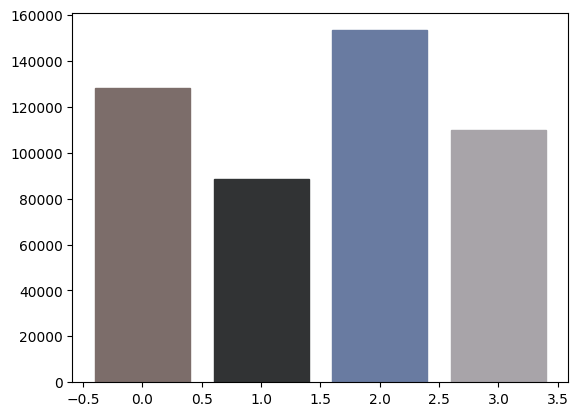

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9']}


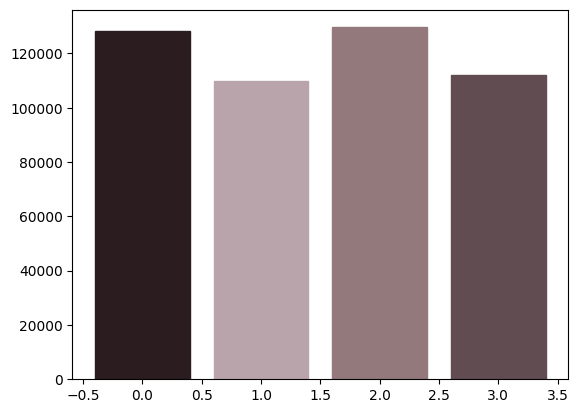

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52']}


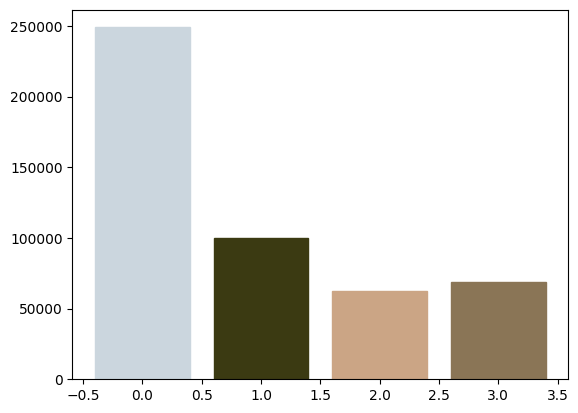

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556']}


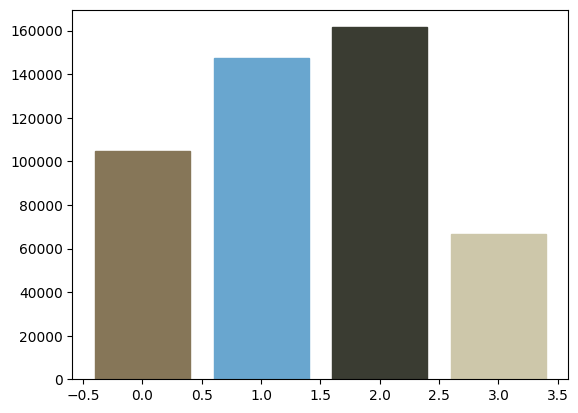

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa']}


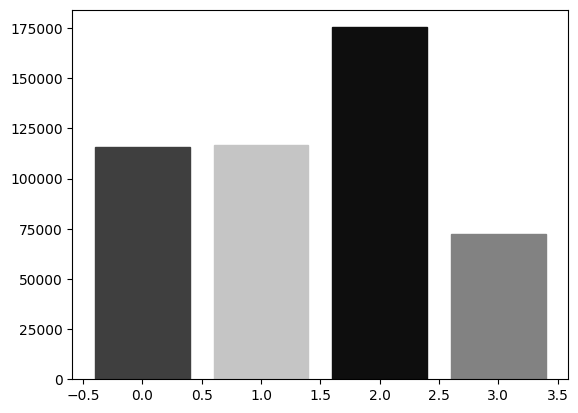

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282']}


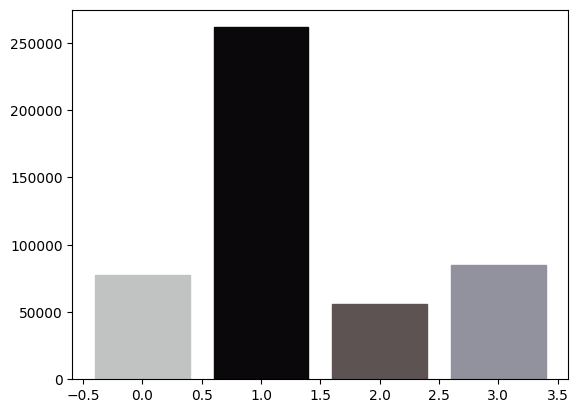

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e']}


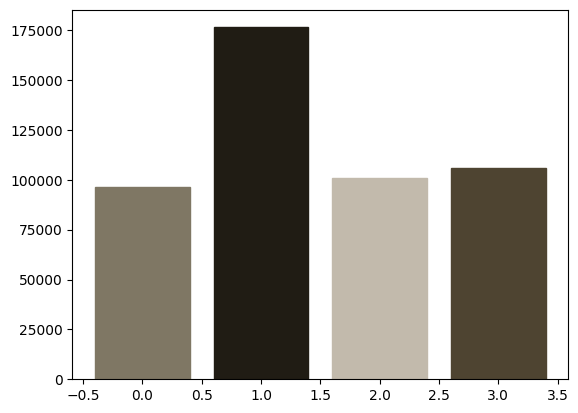

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431']}


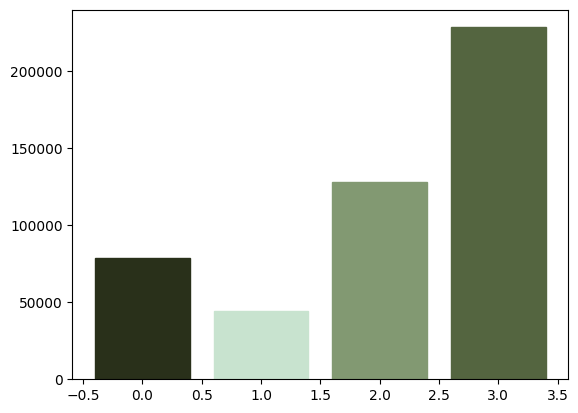

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540']}


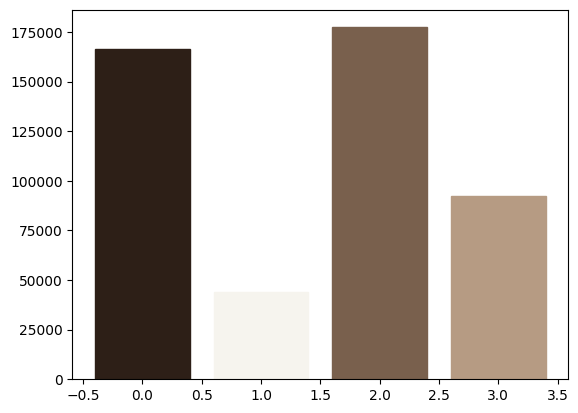

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83']}


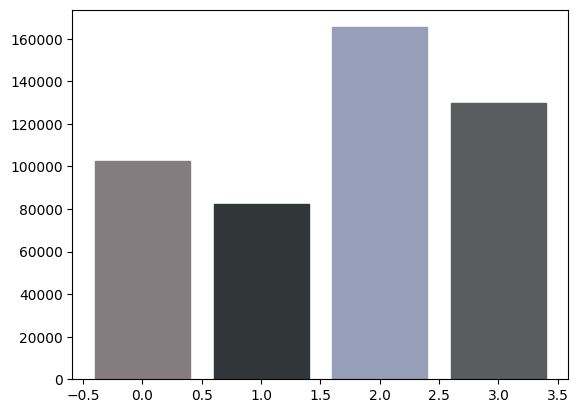

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d']}


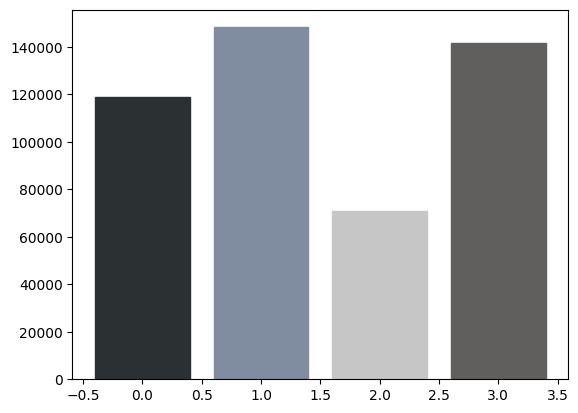

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e']}


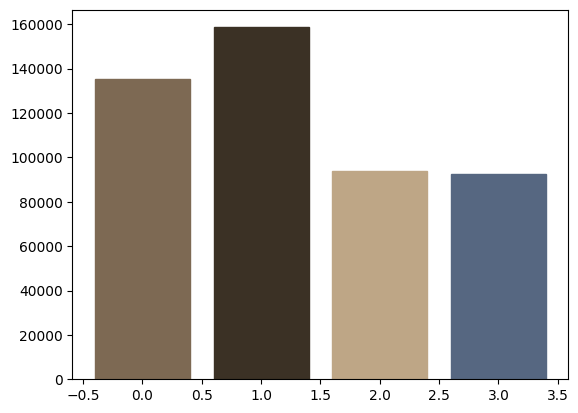

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781']}


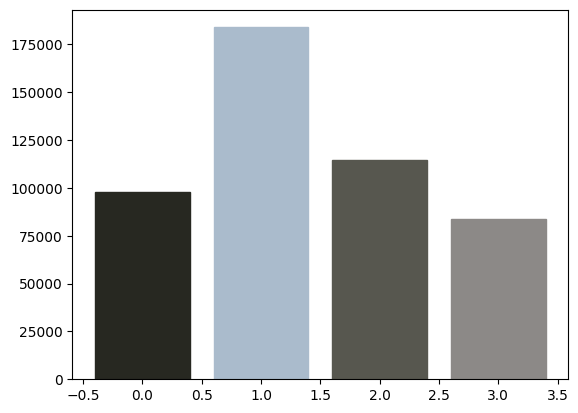

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987']}


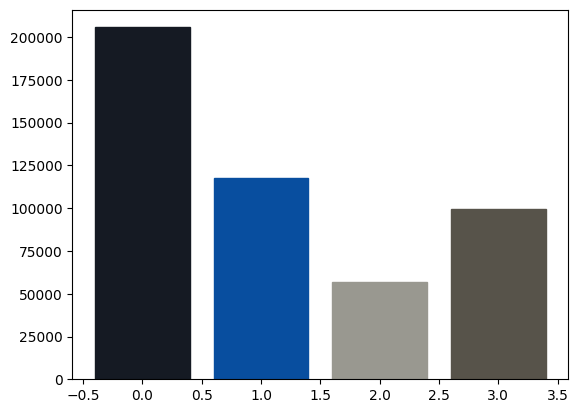

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

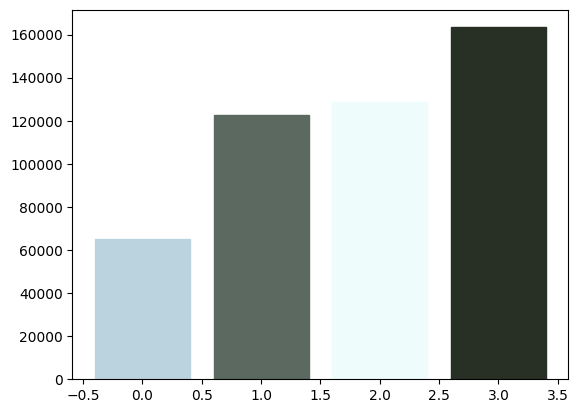

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

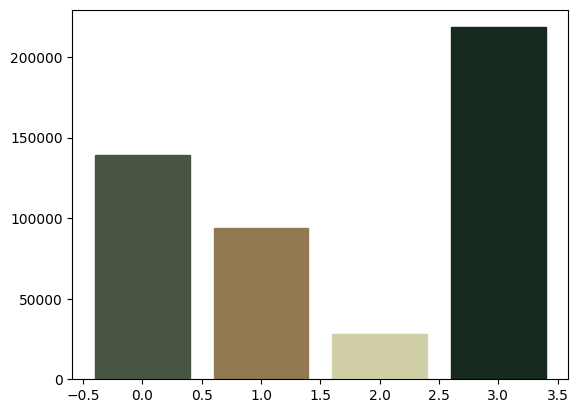

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

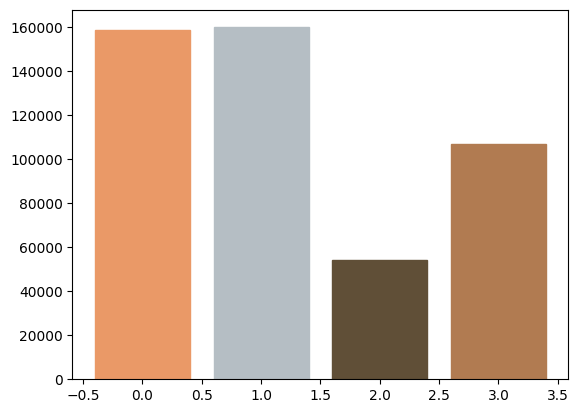

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

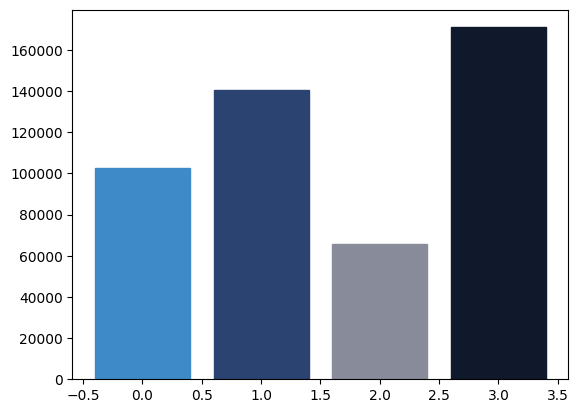

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

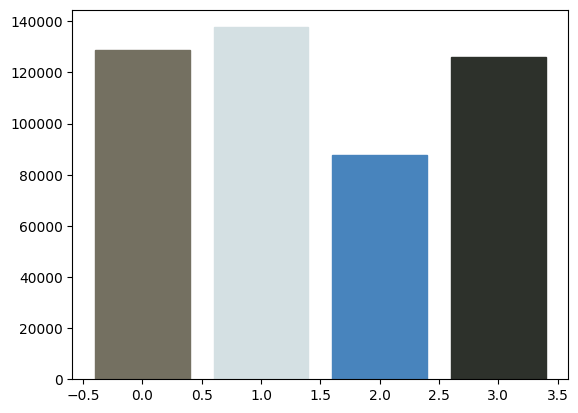

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

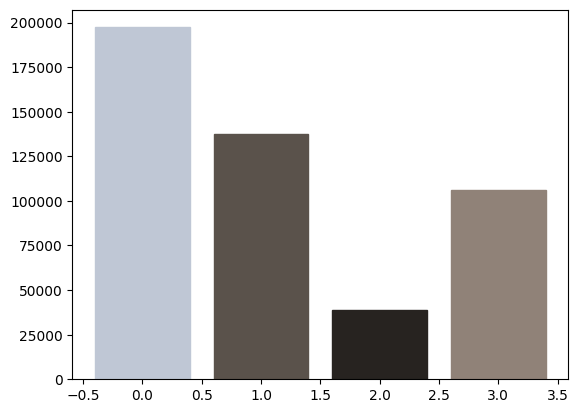

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

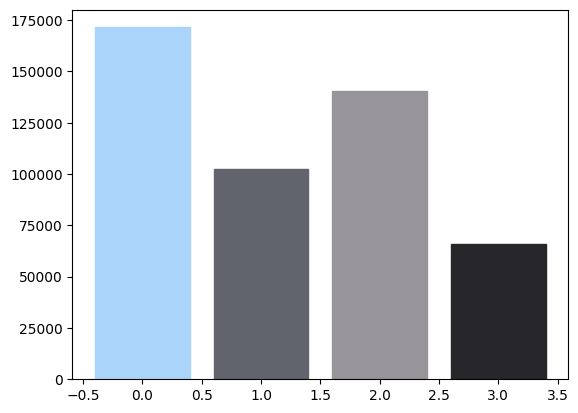

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

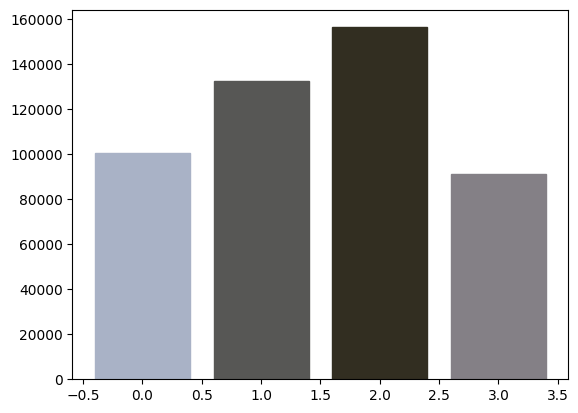

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

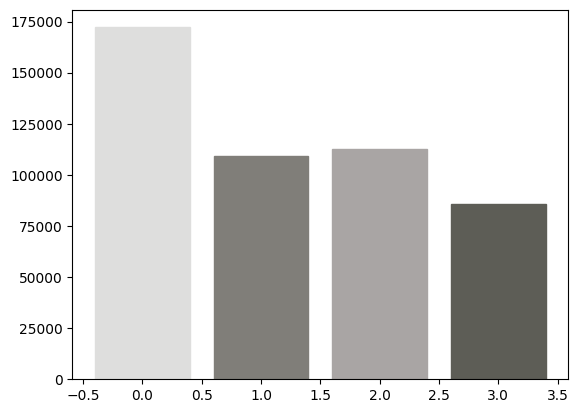

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

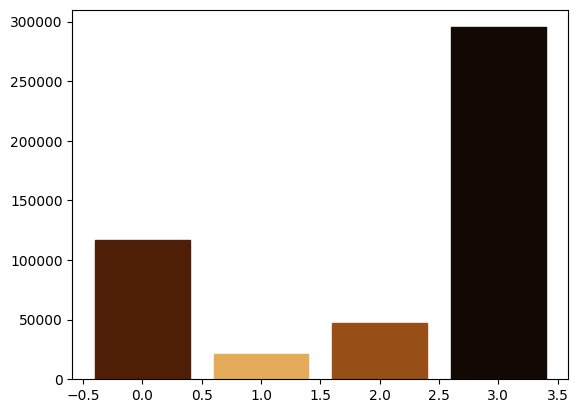

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

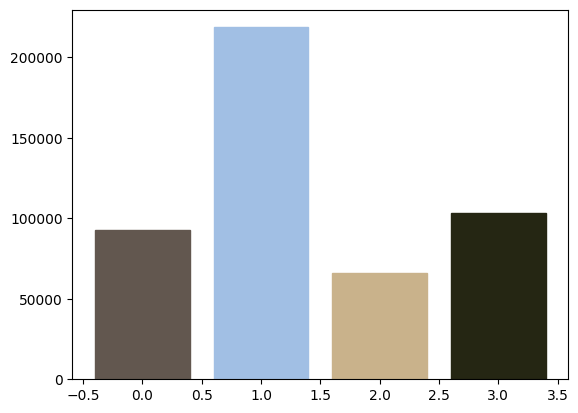

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

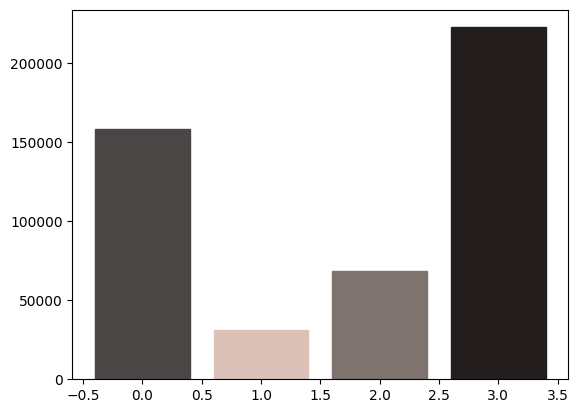

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

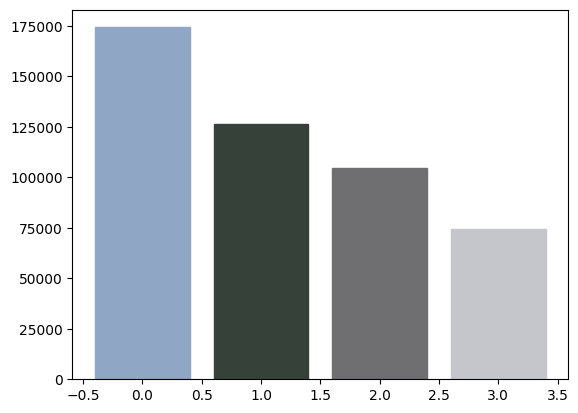

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

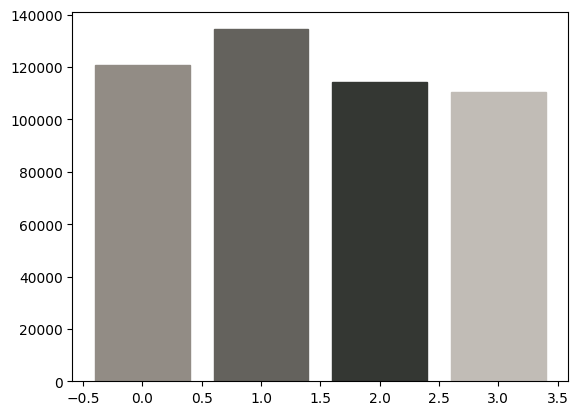

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

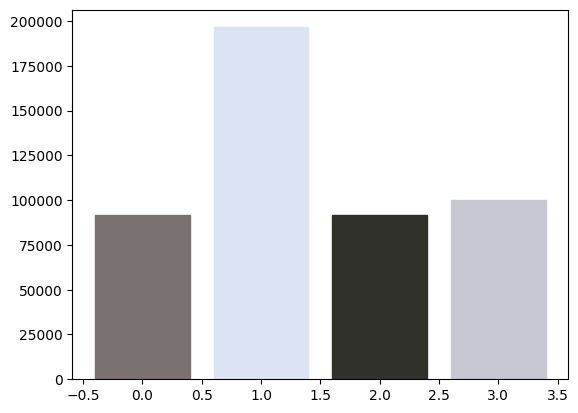

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

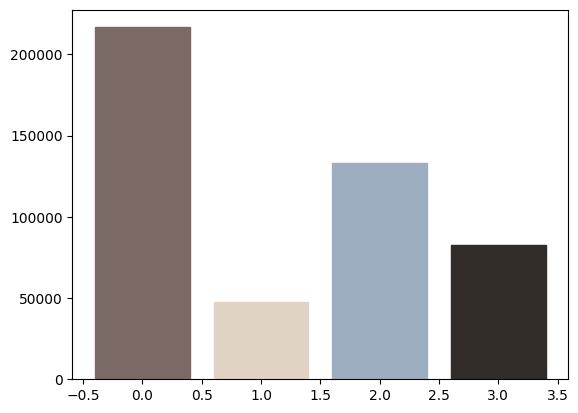

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

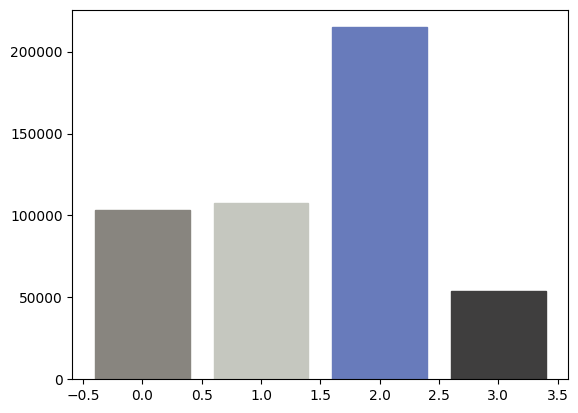

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

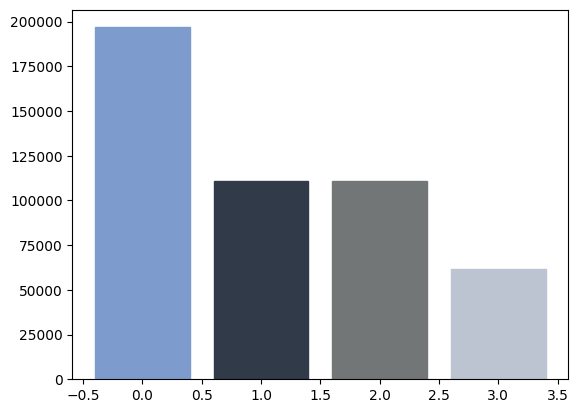

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

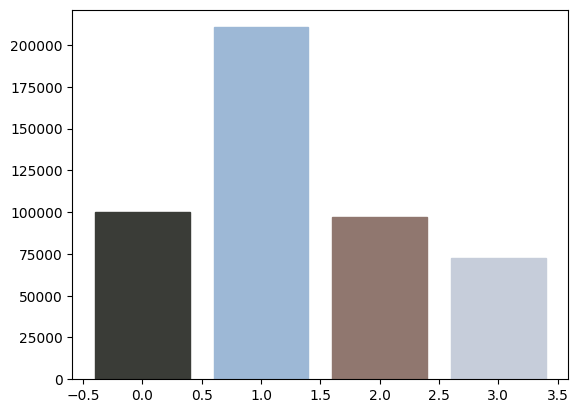

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

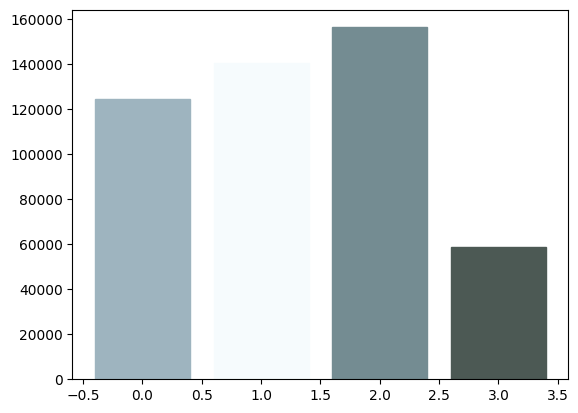

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

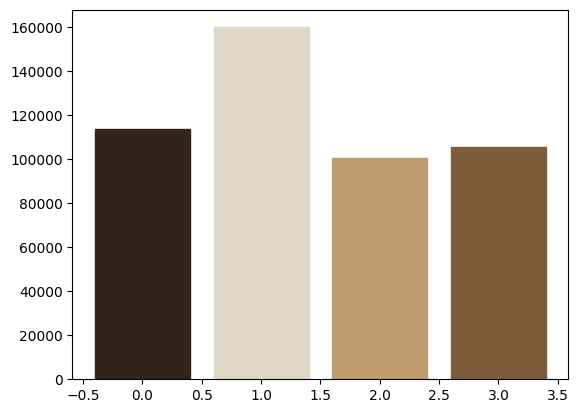

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

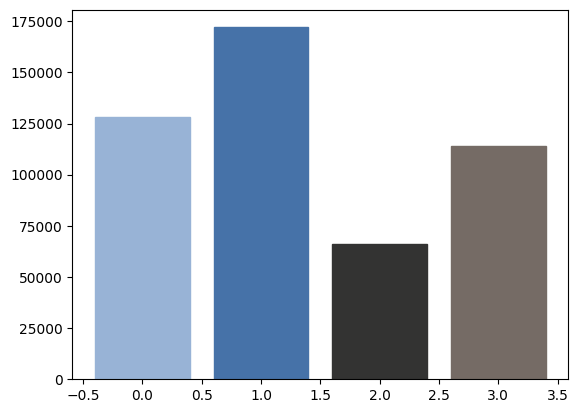

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

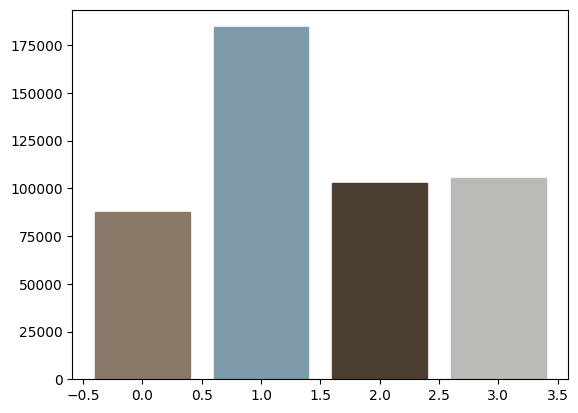

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

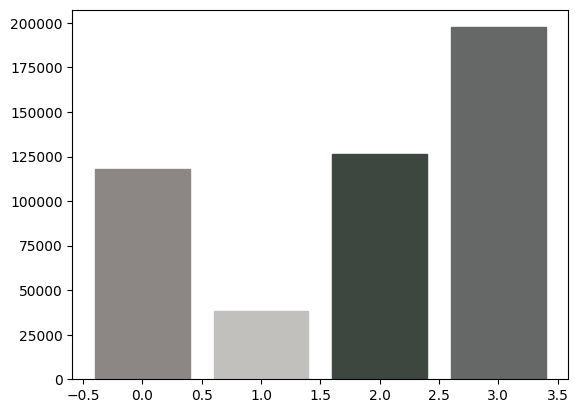

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

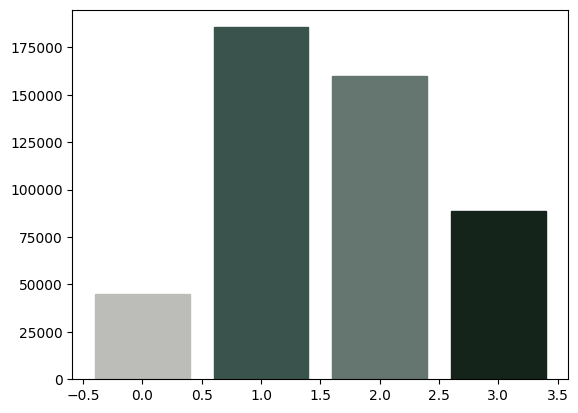

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

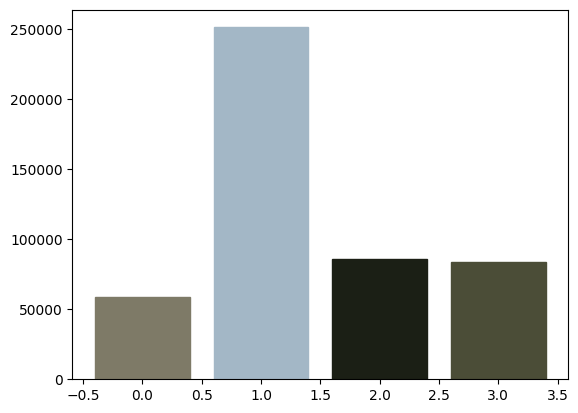

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

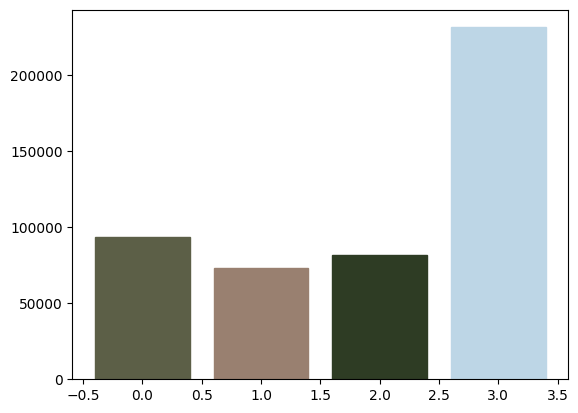

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

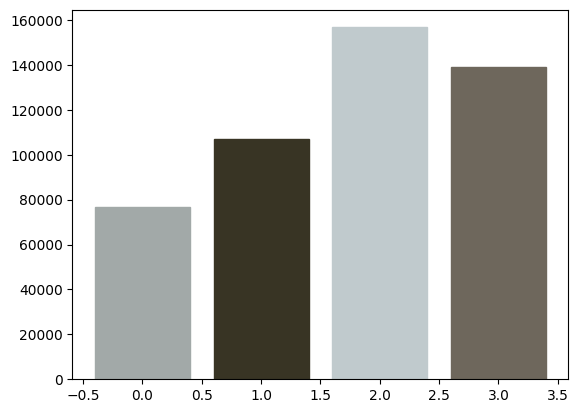

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

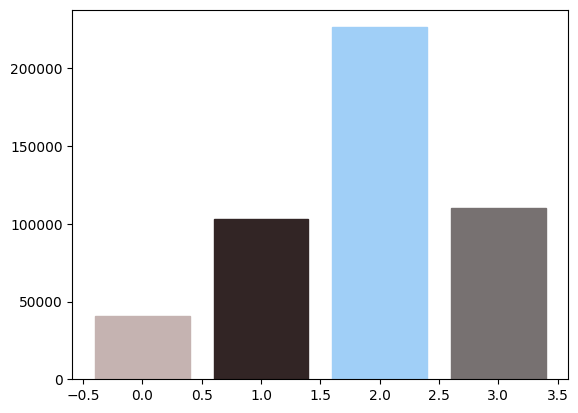

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

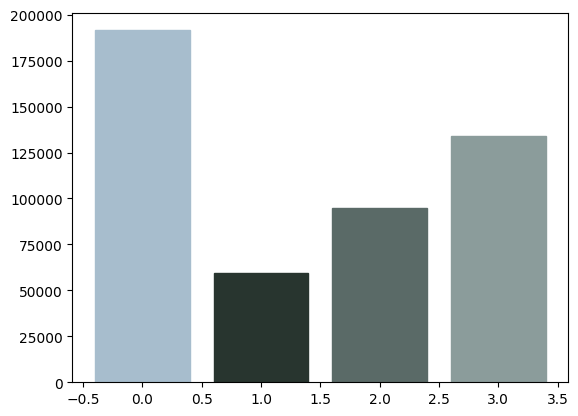

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

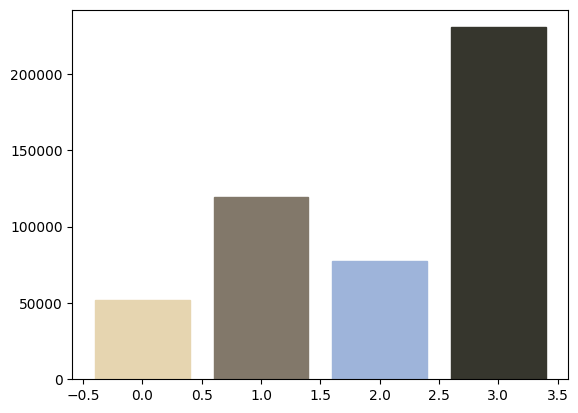

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

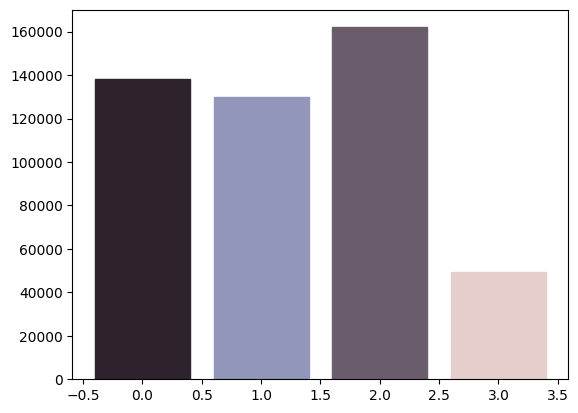

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

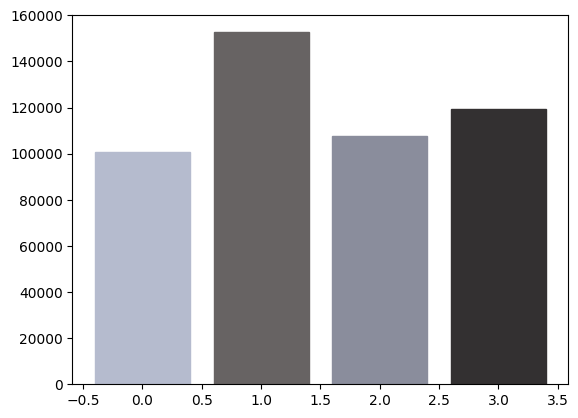

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

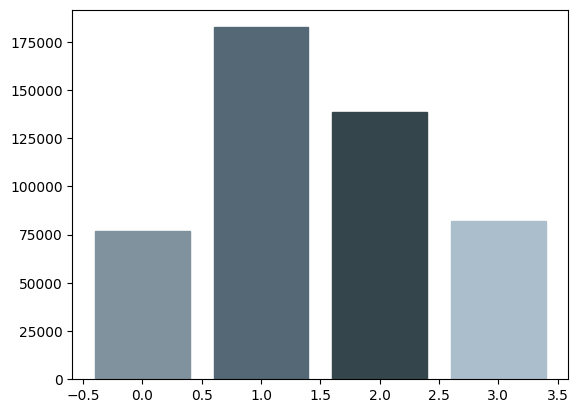

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

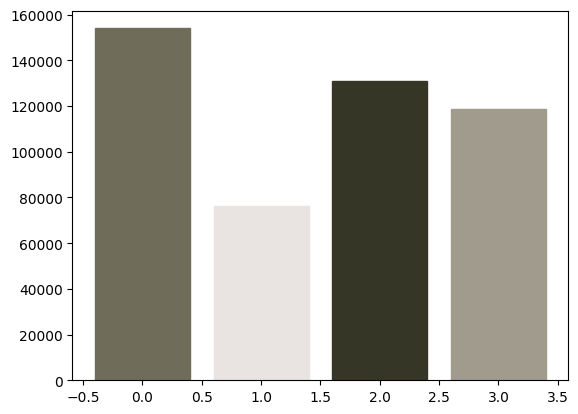

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

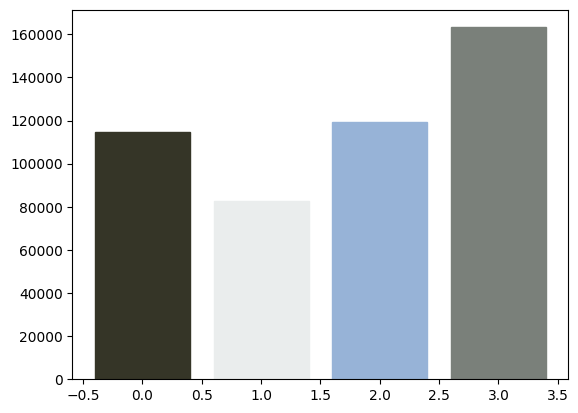

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

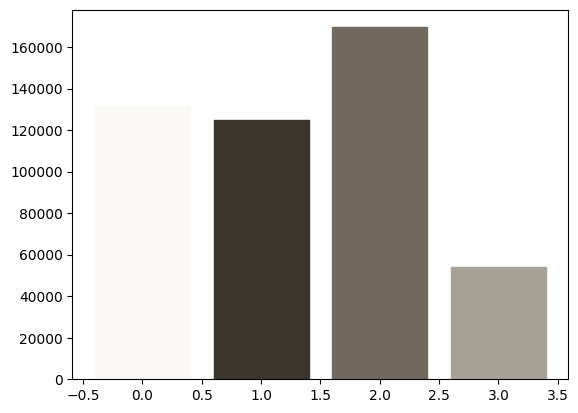

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

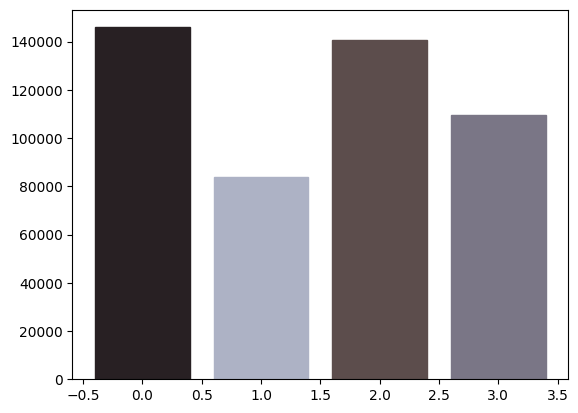

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

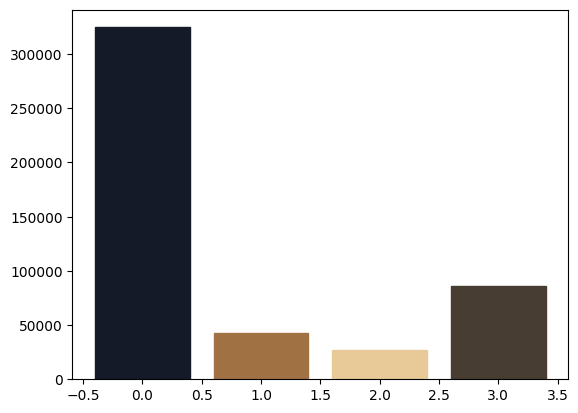

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

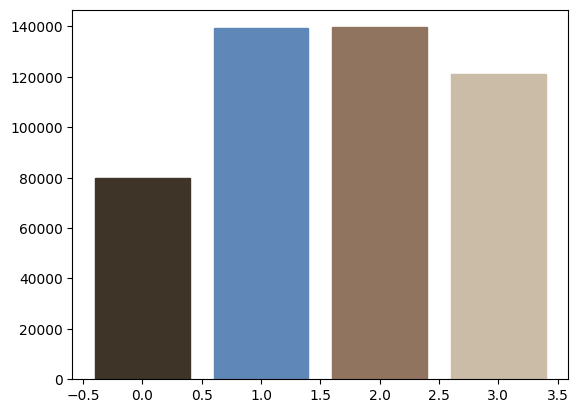

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

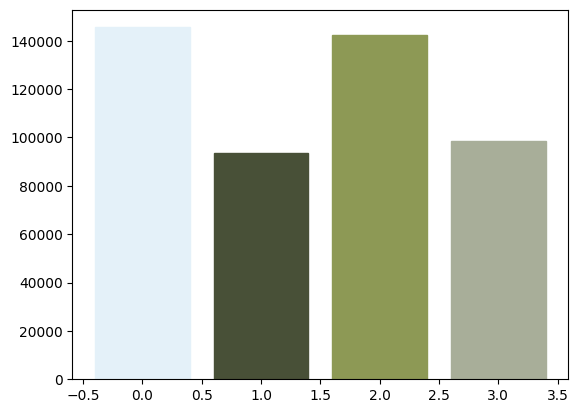

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

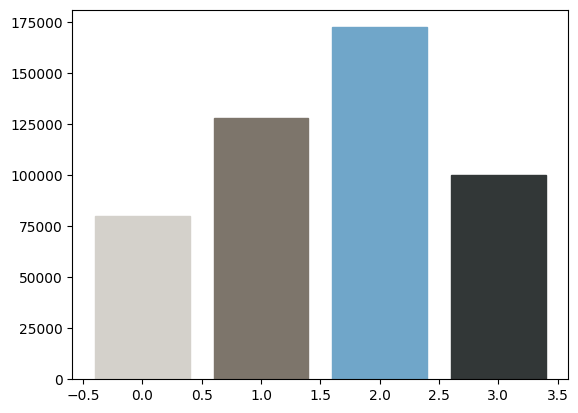

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

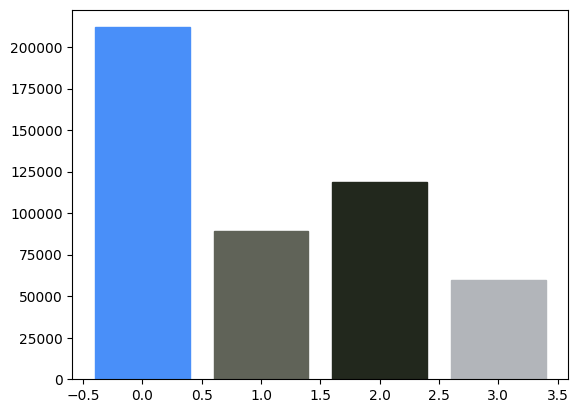

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

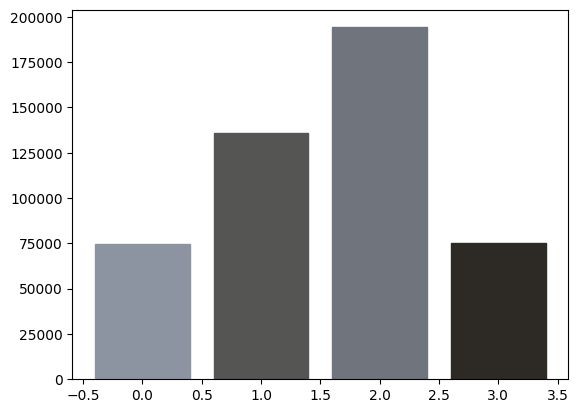

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

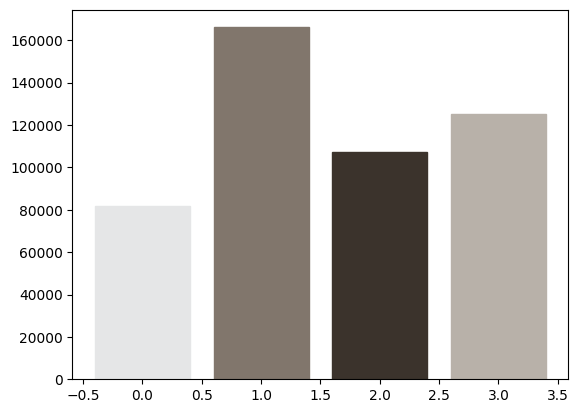

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

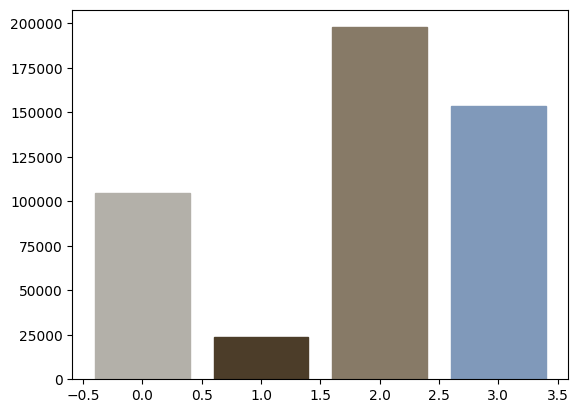

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

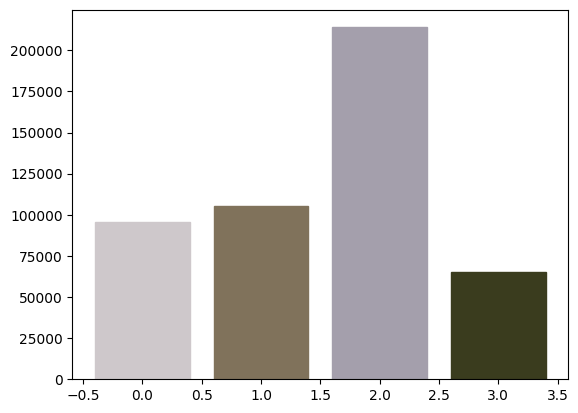

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

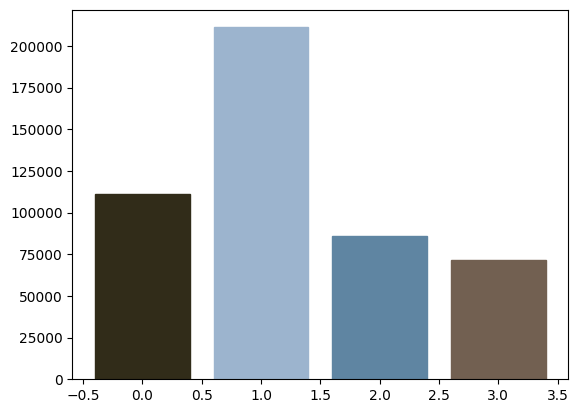

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

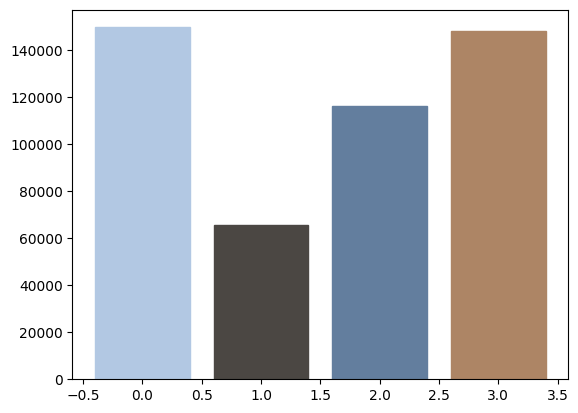

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

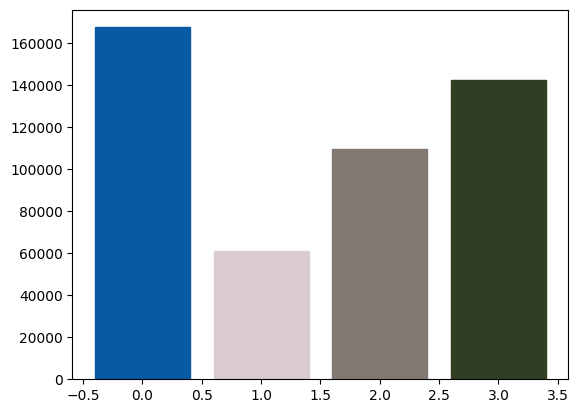

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

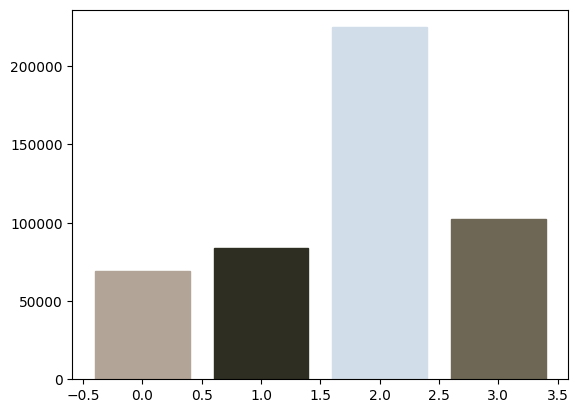

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

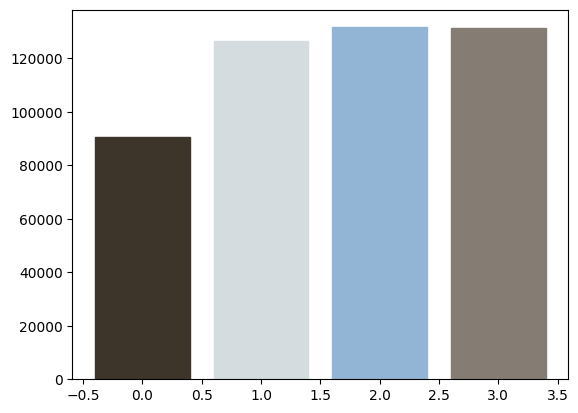

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

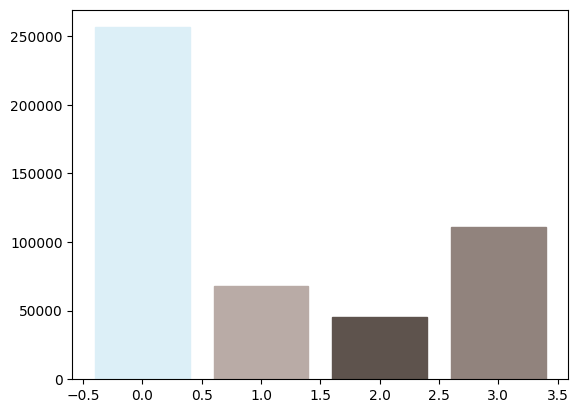

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

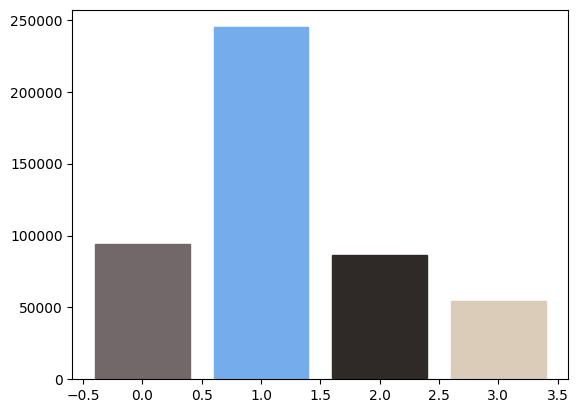

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

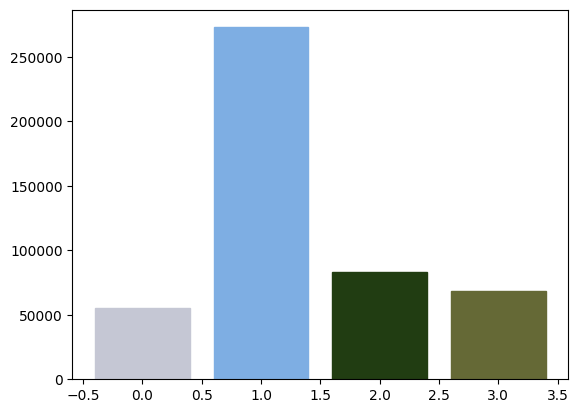

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

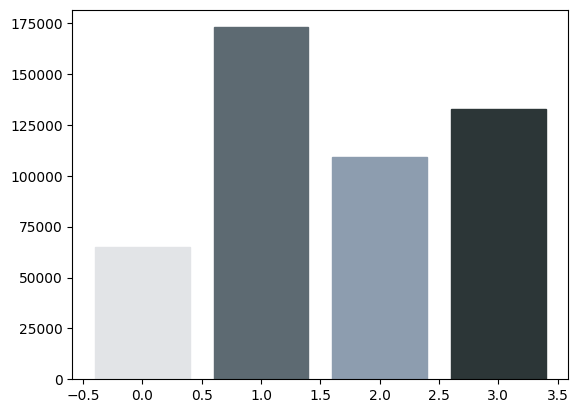

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

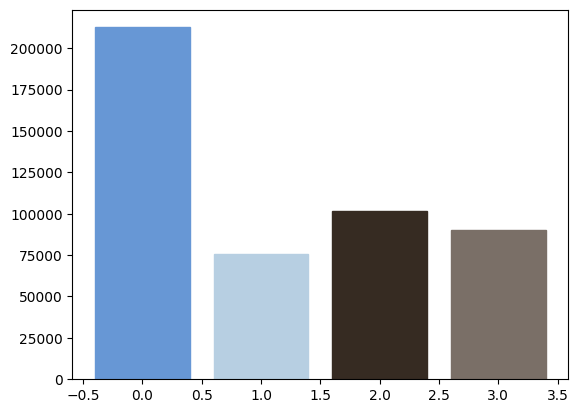

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

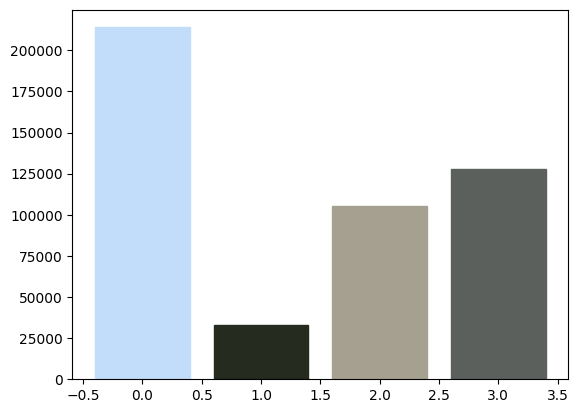

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

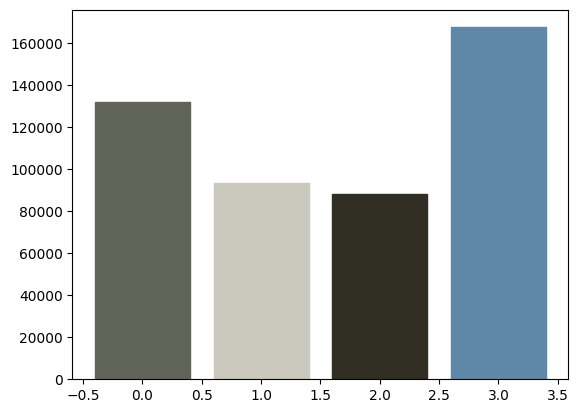

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

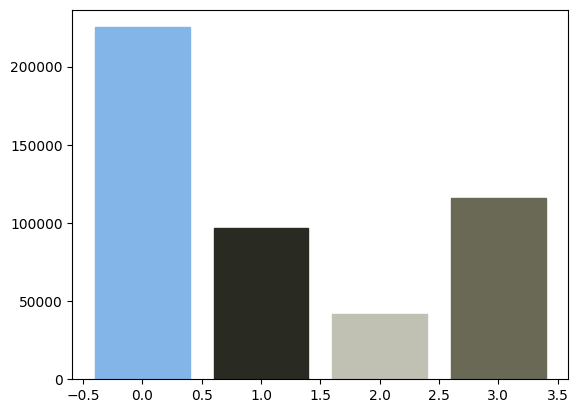

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

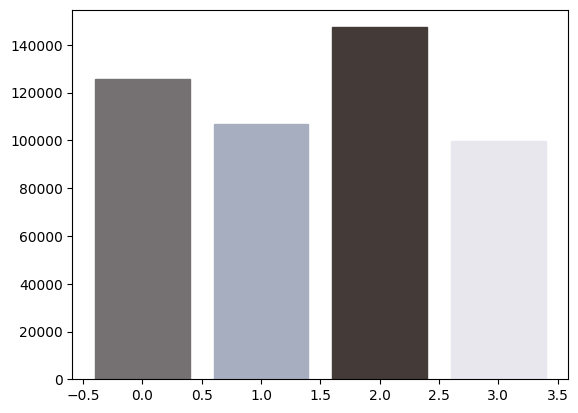

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

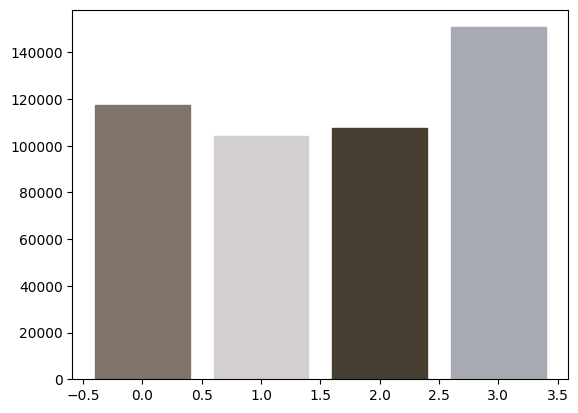

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

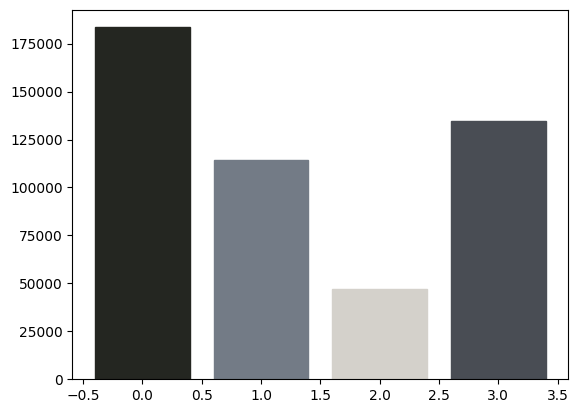

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

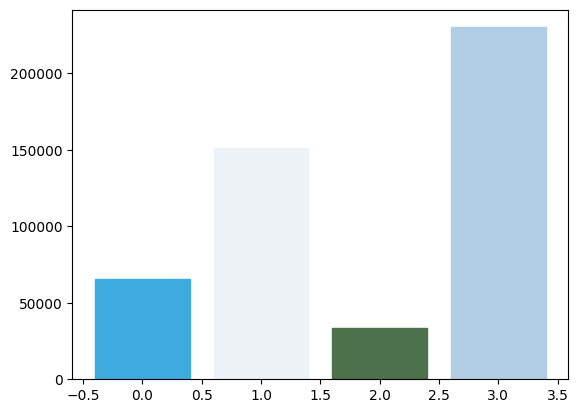

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

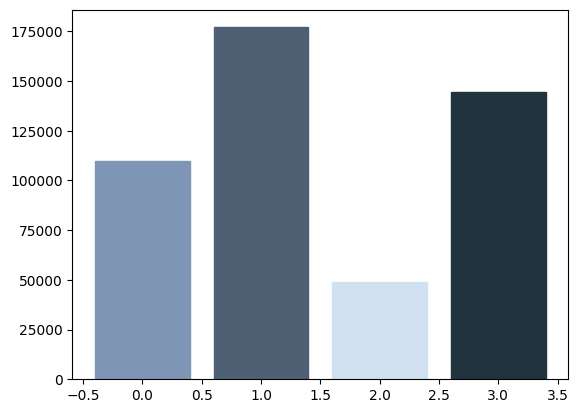

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

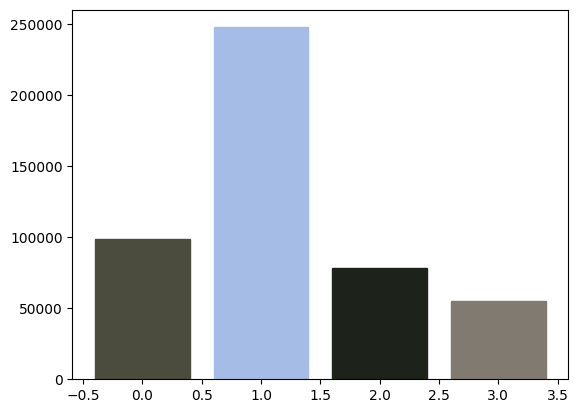

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

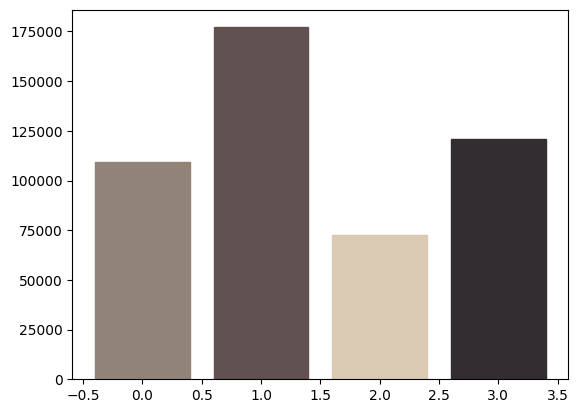

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

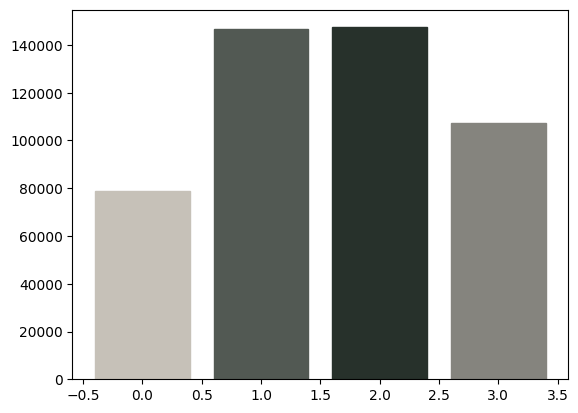

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

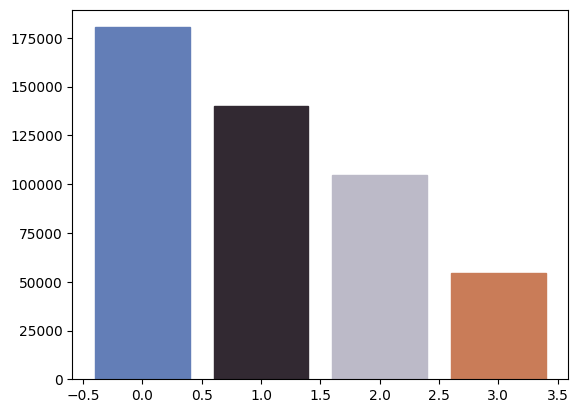

{'00 3178 Sydney, Australia.jpg': ['#7c6d6a', '#313334', '#697ba1', '#a8a4a9'], '15-Nouakchott-eH-R0058185.jpg': ['#2b1c1f', '#baa4ab', '#93797b', '#614c52'], '20130610 - Monumento aos Heróis da Independência.jpg': ['#cbd6de', '#3b3a12', '#cba585', '#8a7556'], 'Addis abeba meskele square.jpg': ['#867658', '#69a6cf', '#3a3c32', '#cdc7aa'], 'Alger monochrome.jpg': ['#3f3f3f', '#c5c5c5', '#0e0e0e', '#828282'], 'Algiers Grand Post.jpg': ['#c1c3c3', '#0a080b', '#5d5352', '#92929e'], 'Algiers in the morning.jpg': ['#7f7764', '#201c14', '#c2baac', '#4e4431'], "Algiers's Airport.jpg": ['#29301a', '#c8e3cf', '#829972', '#546540'], 'AMMAN 2.jpg': ['#2d1f17', '#f6f4ee', '#79604d', '#b69b83'], 'AnkonPanorama.jpg': ['#847c7f', '#313639', '#969fb7', '#5b5c5d'], 'Argel 3.jpg': ['#2b3133', '#808da0', '#c7c6c6', '#605f5e'], 'Asmara2.jpg': ['#7d6953', '#3b3125', '#bea686', '#566781'], 'Asunción Paraguay.jpg': ['#272821', '#aabbcc', '#57574f', '#8c8987'], 'At night in Algiers, Algeria.jpg': ['#151a23', '

In [61]:
# Get color for all my images files
import json

def metadata_color_images():
    images = get_all_images()
    color_metadata = {}
    for image in images:
        try:
            color_metadata[image] = get_color(f"images/{image}")
            print(color_metadata)
        except Exception as e:
            continue
    with open("color_data.json","w") as file:
        json.dump(color_metadata, file, default=str, indent=4)
    return

metadata_color_images()

# III] Mise en place des tags sur les images #

In [72]:
# get tags for all images
import requests
import json
import os
from bs4 import BeautifulSoup

def get_tags(image_path):
    starturl = "https://commons.wikimedia.org/wiki/File:"
    filename = os.path.basename(image_path)
    url = starturl + filename
    response = requests.get(url)

    tags = []

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        # Trouver les balises de catégorie
        categories = soup.find_all('div', class_='mw-normal-catlinks')[0].find_all('a')

        for category in categories:
            if category.text == 'Categories' or 'Category' in category.text:
                continue
            tags.append(category.text)

    return tags

# Exemple d'utilisation
image_path = "images/MonroviaLB14.png"
tags = get_tags(image_path)
print("Catégories de l'image :", tags)  

Catégories de l'image : ['Monrovia', 'Montages of cities in Liberia']


In [74]:
# Get the tags of all images
import json

def get_all_images_tags():
    images = get_all_images()
    tags = {}
    for image in images:
        try:
            tags[image] = get_tags(f"images/{image}")
            print(image, " : ", tags[image])
        except Exception as e:
            continue
    with open("all_tags.json","w") as file:
        json.dump(tags, file, default=str, indent=4)
    return

get_all_images_tags()

00 3178 Sydney, Australia.jpg  :  ['Central Business District, Sydney', 'April 2006 in Sydney CBD']
15-Nouakchott-eH-R0058185.jpg  :  ['Nouakchott', 'Streets in Nouakchott']
20130610 - Monumento aos Heróis da Independência.jpg  :  ['Praça dos Heróis Nacionais', 'Monumento aos Heróis da Independência (Bissau)', '2013 in Guinea-Bissau', 'Hotel Império']
Addis abeba meskele square.jpg  :  ['2021 in Addis Ababa', 'Views of Addis Ababa']
Alger monochrome.jpg  :  ['Alger Centre', 'Algiers', 'Rue Michelet (Algiers)']
Algiers Grand Post.jpg  :  ["Grande Poste d'Alger"]
Algiers in the morning.jpg  :  ['Algiers']
Algiers's Airport.jpg  :  ['Algiers Houari Boumediene Airport']
AMMAN 2.jpg  :  ['Views of Amman', 'Montages of cities in Jordan']
AnkonPanorama.jpg  :  ['Aerial photographs of Ancona']
Argel 3.jpg  :  ['Aerial photographs of Algiers Province']
Asmara2.jpg  :  ['Aerial views of Asmara']
Asunción Paraguay.jpg  :  ['Skyline of Asunción']
At night in Algiers, Algeria.jpg  :  ['Algiers Prov

KeyboardInterrupt: 